# **Python assignment**

In [2]:
# ---------------------------------------------------------
# File Name: MidTermAssignment.py
# Description: 
# Autor: Prat Paul; Gavini Charles; Fournier Justin; Blanc Mathieu
# Creation Date: 2024-10-16
# Version: 1.0
# ---------------------------------------------------------

Installing yahoofinance

In [3]:
#pip install yfinance

Installing statsmodels

In [4]:
#pip install statsmodels

In [5]:
#importations
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from statsmodels.graphics.tsaplots import plot_acf # import this function from this submodule
import statsmodels.api as sm
import scipy.stats as stats
from scipy.stats import gaussian_kde, norm, iqr, skew, kurtosis, jarque_bera, kstest, anderson
from statsmodels.stats.diagnostic import lilliefors
import scipy.signal as ss
import pylab

# *First pandas dataframe of Amazon stocks*

In [6]:
# Importing Amazon stock from yahoo finance
Amazon = yf.download("AMZN", start="1999-01-21", end="2024-10-16")
Amazon.head()

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
1999-01-21,2.612500,2.759375,2.314063,2.650000,2.650000,940964000
1999-01-22,2.487500,3.146875,2.468750,3.075000,3.075000,875316000
1999-01-25,3.037500,3.084375,2.750000,2.809375,2.809375,546476000
1999-01-26,2.815625,3.031250,2.765625,2.877344,2.877344,490696000
1999-01-27,3.353125,3.493750,3.000000,3.140625,3.140625,700452000


In [7]:
#pip install perfplot

In [8]:
latex_table = Amazon.head().to_latex(index=True)
with open("Latex/table.tex", "w") as file:
    file.write(latex_table)

/var/folders/5r/ft807c7n1ngd3fpt2_gwsg0m0000gn/T/ipykernel_21816/3304008134.py:1: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  latex_table = Amazon.head().to_latex(index=True)


# *Cheking if timestamp is 25 years*

In [9]:
print('Amazon data range is: ',Amazon.index[0],Amazon.index[-1])

#trying to find gaps

#First create a dataframe for a fullrange of our index, without any gap with the following formula: 
full_range = pd.date_range(start=Amazon.index.min(), end=Amazon.index.max(), freq='B')

#Then compare to our dataframe: 

MissingDays=full_range.difference(Amazon.index)

#Print the count and the detail preview:
print('Missing Days count is: ',len(MissingDays))
print("missing dates",MissingDays)

#We can see that data have ponctual gaps, no issue here we can still use it

Amazon data range is:  1999-01-21 00:00:00 2024-10-15 00:00:00
Missing Days count is:  238
missing dates DatetimeIndex(['1999-02-15', '1999-04-02', '1999-05-31', '1999-07-05',
               '1999-09-06', '1999-11-25', '1999-12-24', '2000-01-17',
               '2000-02-21', '2000-04-21',
               ...
               '2023-11-23', '2023-12-25', '2024-01-01', '2024-01-15',
               '2024-02-19', '2024-03-29', '2024-05-27', '2024-06-19',
               '2024-07-04', '2024-09-02'],
              dtype='datetime64[ns]', length=238, freq=None)


In [10]:
Amazon.index
#extracting adjusted
Nv_adj=Amazon['Adj Close']
Nv_adj.index = Amazon.index

#display first 5 rows, now it is a pandas series instead of a dataframe
Nv_adj.head()

Date
1999-01-21    2.650000
1999-01-22    3.075000
1999-01-25    2.809375
1999-01-26    2.877344
1999-01-27    3.140625
Name: Adj Close, dtype: float64

For the possible gaps in data, we plot them here

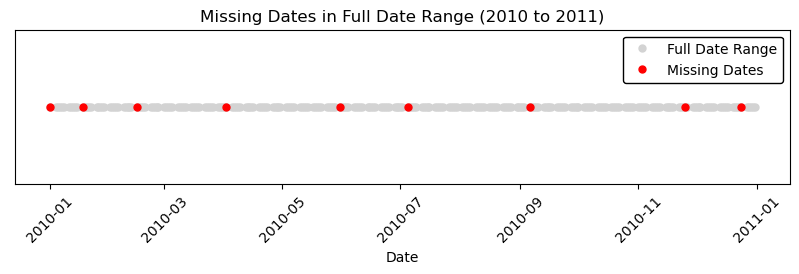

In [11]:
#plot the missing dates
full_data = Amazon.reindex(full_range)

#zoom in over one year
start_date = "2010-01-01"
end_date = "2011-01-01"
filtered_full_range = full_range[(full_range >= start_date) & (full_range <= end_date)]
filtered_missing_dates = MissingDays[(MissingDays >= start_date) & (MissingDays <= end_date)]

plt.figure(figsize=(10, 2))

# Plot all dates in the filtered range with gray dots (showing the full timeline for this period)
plt.plot(filtered_full_range, [1] * len(filtered_full_range), 'o', color='lightgray', markersize=5, label="Full Date Range")

# Overlay red dots only on the missing dates within the filtered range
plt.plot(filtered_missing_dates, [1] * len(filtered_missing_dates), 'ro', markersize=5, label="Missing Dates")

# Customize plot
plt.title("Missing Dates in Full Date Range (2010 to 2011)",color='black')
plt.xlabel("Date",color='black')
plt.yticks([])  # Hide y-axis labels for clarity
plt.xticks(rotation=45,color='black')
plt.legend(facecolor='white', edgecolor='black', framealpha=1, fontsize=10)

#Saving the plot in pdf format
plt.savefig('Latex/Img/MissingDates(2010_to_2011).pdf', format='pdf', bbox_inches='tight')

plt.show()


In [12]:
# extract the closing prices of the Amazon stok (as in lecture)
Pt_d_all = Amazon["Adj Close"]
Pt_d_all = Pt_d_all.rename('Pt.d')
# mutate the Index into a DatetimeIndex
Pt_d_all.index = pd.to_datetime(Pt_d_all.index)
Pt_d_all.head()

Date
1999-01-21    2.650000
1999-01-22    3.075000
1999-01-25    2.809375
1999-01-26    2.877344
1999-01-27    3.140625
Name: Pt.d, dtype: float64

Compute log price

In [13]:
pt_d_all = np.log(Pt_d_all)
pt_d_all = pt_d_all.rename('pt.d')
pt_d_all.head()

Date
1999-01-21    0.974560
1999-01-22    1.123305
1999-01-25    1.032962
1999-01-26    1.056868
1999-01-27    1.144422
Name: pt.d, dtype: float64

Compute weekly monthly and yearly

In [14]:
pt_w_all = pt_d_all.resample('W').last()
pt_m_all = pt_d_all.resample('M').last()
pt_y_all = pt_d_all.resample('Y').last()
# and rename them:
pt_w_all = pt_w_all.rename('pt.w.all')
pt_m_all = pt_m_all.rename('pt.m.all')
pt_y_all = pt_y_all.rename('pt.y.all')

#idem for simply prices
Pt_w_all = Pt_d_all.resample('W').last()
Pt_m_all = Pt_d_all.resample('M').last()
Pt_y_all = Pt_d_all.resample('Y').last()
# and rename them:
Pt_w_all = Pt_w_all.rename('Pt_w_all')
Pt_m_all = Pt_m_all.rename('Pt_m_all')
Pt_y_all = Pt_y_all.rename('Pt_y_all')


Plot the simple prices

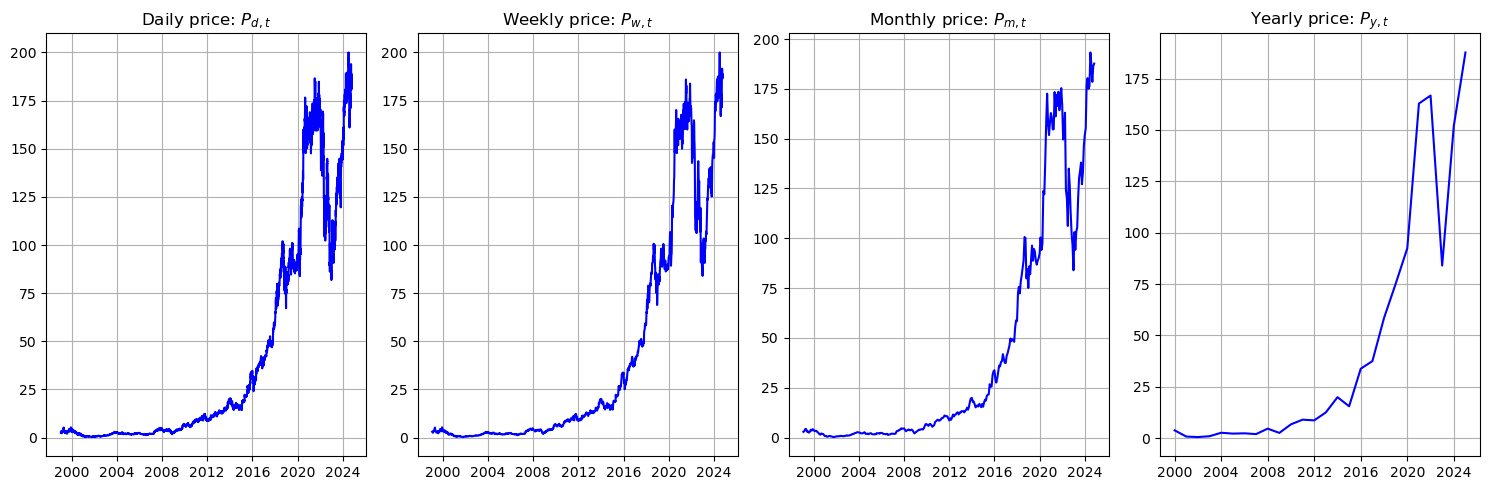

In [15]:
# set the 1x4 windows layout
fig, axs = plt.subplots(1, 4, figsize=(15, 5))
# Daily Price
axs[0].plot(Pt_d_all.index, Pt_d_all, color='blue')
axs[0].set_title('Daily price: $P_{d,t}$')
axs[0].grid(True)
# Weekly price
axs[1].plot(Pt_w_all.index, Pt_w_all, color='blue')
axs[1].set_title('Weekly price: $P_{w,t}$')
axs[1].grid(True)
# Monthly price
axs[2].plot(Pt_m_all.index, Pt_m_all, color='blue')
axs[2].set_title('Monthly price: $P_{m,t}$')
axs[2].grid(True)
#Yearly price
axs[3].plot(Pt_y_all.index, Pt_y_all, color='blue')
axs[3].set_title('Yearly price: $P_{y,t}$')
axs[3].grid(True)

# Manage margings and plot
plt.tight_layout()
plt.savefig('Latex/Img/prices_time.pdf', format='pdf', bbox_inches='tight')
plt.show()

Adding python code to the latex document in the appendix part

In [16]:
#Test for incorporating python code into the appendix section in the latex document
code_content = r"""
\section{Appendix: Python Code}
Below is the Python code used in this analysis.

\begin{lstlisting}[language=Python, caption=Python Code for Analysis]
# Python code example
import numpy as np
import pandas as pd

def analyze_data(data):
    mean = np.mean(data)
    std_dev = np.std(data)
    return mean, std_dev

data = [1, 2, 3, 4, 5]
mean, std_dev = analyze_data(data)
print(f"Mean: {mean}, Standard Deviation: {std_dev}")
\end{lstlisting}
"""

# Write to the 'code_appendix.tex' file
with open("Latex/code_appendix.tex", "w") as file:
    file.write(code_content)

# *Calculating returns*

In [17]:
#calculating return

#log returns

rt_d_all_temp = pt_d_all.diff()
rt_d_all_temp

Date
1999-01-21         NaN
1999-01-22    0.148745
1999-01-25   -0.090343
1999-01-26    0.023906
1999-01-27    0.087554
                ...   
2024-10-09    0.013319
2024-10-10    0.007961
2024-10-11    0.011559
2024-10-14   -0.006802
2024-10-15    0.000800
Name: pt.d, Length: 6476, dtype: float64

Compute daily, weekly, and monthly

In [18]:
rt_d_all = pt_d_all.diff().dropna() #dropna remove the first NaN
rt_w_all = pt_w_all.diff().dropna()  
rt_m_all = pt_m_all.diff().dropna()     
rt_y_all = pt_y_all.diff().dropna()      

# and rename them: 
rt_d_all = rt_d_all.rename('rt_d_all')
rt_w_all = rt_w_all.rename('rt_w_all')
rt_m_all = rt_m_all.rename('rt_m_all')
rt_y_all = rt_y_all.rename('rt_y_all')
rt_d_all.head()

Date
1999-01-22    0.148745
1999-01-25   -0.090343
1999-01-26    0.023906
1999-01-27    0.087554
1999-01-28   -0.022134
Name: rt_d_all, dtype: float64

The first returns are correctly computed, we have to be careful to the dropna

Let's plot returns

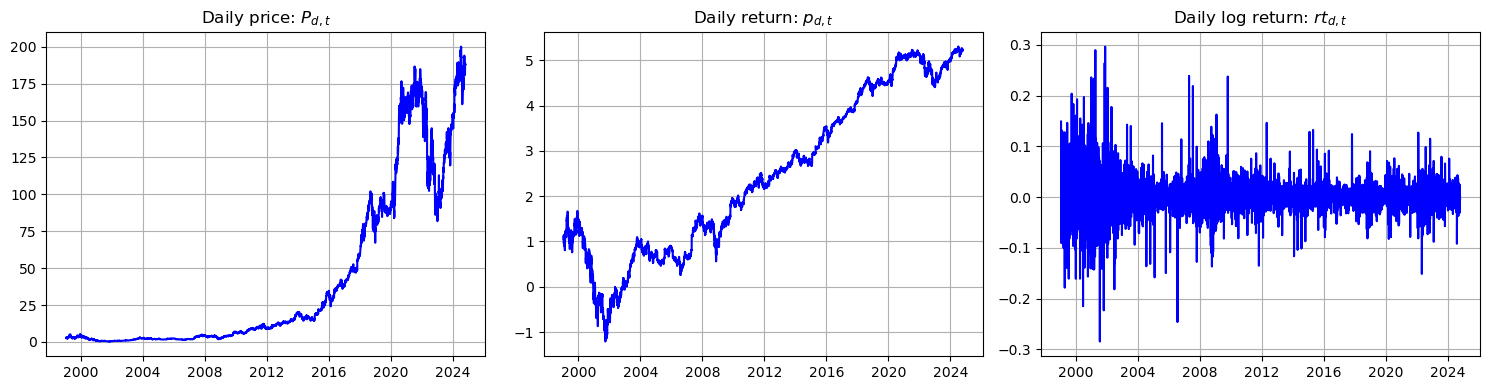

In [19]:
# set the 1x3 windows layout
fig, axs = plt.subplots(1, 3, figsize=(15, 4))
# Daily Price
axs[0].plot(Pt_d_all.index, Pt_d_all, color='blue')
axs[0].set_title('Daily price: $P_{d,t}$')
axs[0].grid(True)
# Daily log price
axs[1].plot(pt_d_all.index, pt_d_all, color='blue')
axs[1].set_title('Daily return: $p_{d,t}$')
axs[1].grid(True)
# Daily log returns
axs[2].plot(rt_d_all.index, rt_d_all, color='blue')
axs[2].set_title('Daily log return: $rt_{d,t}$')
axs[2].grid(True)


plt.tight_layout()
plt.savefig('Latex/Img/log_returns.pdf', format='pdf', bbox_inches='tight')
plt.show()

Squared returns

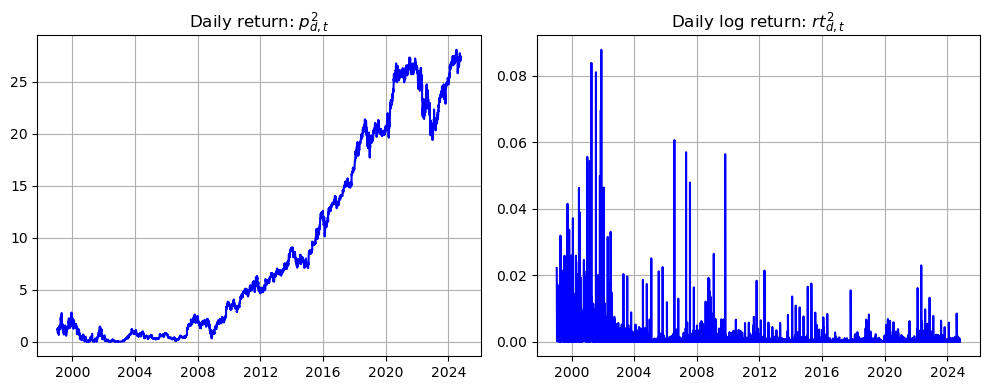

In [20]:
fig, axs = plt.subplots(1, 2, figsize=(10, 4))

# Daily squared log price
axs[0].plot(pt_d_all.index, pt_d_all**2, color='blue')
axs[0].set_title('Daily return: $p_{d,t}^2$')
axs[0].grid(True)
# Daily squared log returns
axs[1].plot(rt_d_all.index, rt_d_all**2, color='blue')
axs[1].set_title('Daily log return: $rt_{d,t}^2$')
axs[1].grid(True)

plt.tight_layout()
plt.savefig('Latex/Img/squared_log_returns.pdf', format='pdf', bbox_inches='tight')
plt.show()

# *Scatterplot of $p_{t} - p_{t-1}$*

First define the function for plotting a scatterplot

In [21]:
def lag1_scatterplot(data, x_label, y_label, title):
    plt.scatter(data.shift(), data, color='blue', s=30) #data.shift is just pt-1 (if t=0 what happend ?)
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.title(title)
    plt.plot([min(data), max(data)], [min(data), max(data)], linestyle='dashed', linewidth=2, color='red')

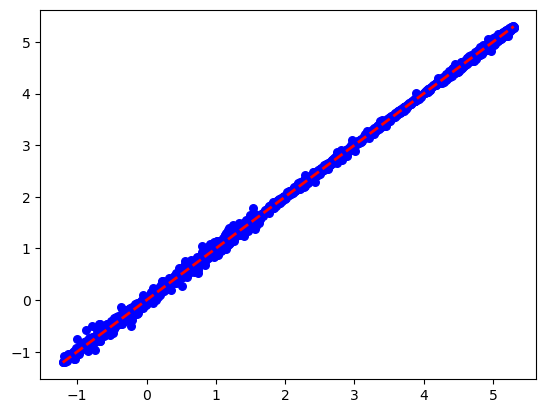

In [22]:
lag1_scatterplot(pt_d_all,"","","")

# Autocorrelation

In [23]:
autocorrelate=pt_d_all.shift().corr(pt_d_all, method='pearson')
print(round(autocorrelate,4))

0.9998


# La suite est copié collé de lecture stylized facts 1

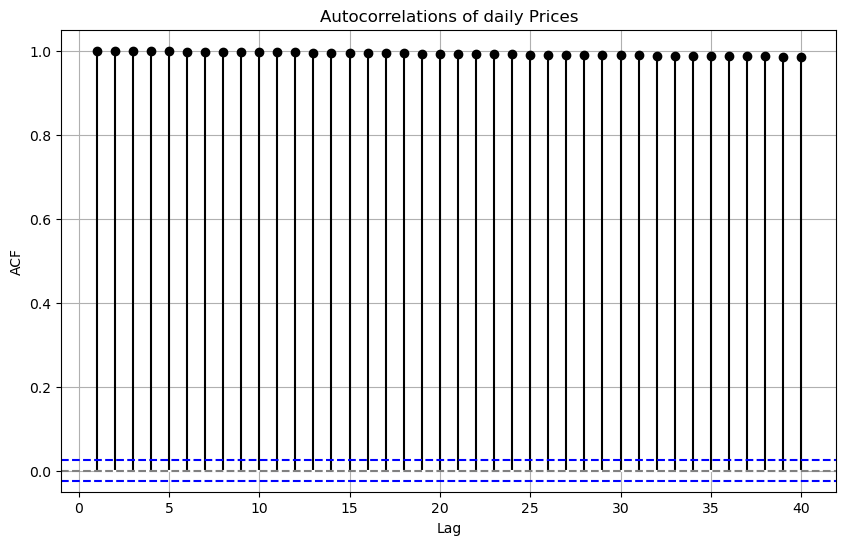

In [24]:
from statsmodels.tsa.stattools import acf

# Calculate empirical autocorrelation
lags = 40
acf_values = acf(pt_d_all, nlags=lags)

# Calculate Bartlett intervals
Bart_Int = 1.96 / np.sqrt(len(pt_d_all))

# Create the autocorrelation plot with Bartlett intervals
plt.figure(figsize=(10, 6))
plt.stem(np.arange(1, lags + 1), acf_values[1:], linefmt='k-', markerfmt='ko', basefmt='w-')
plt.axhline(y=0, color='gray', linestyle='--')
plt.axhline(y=Bart_Int, color='blue', linestyle='--')
plt.axhline(y=-Bart_Int, color='blue', linestyle='--')
plt.title('Autocorrelations of daily Prices')
plt.xlabel('Lag')
plt.ylabel('ACF')
plt.grid(True)

plt.show()

#### ACF with monthly data

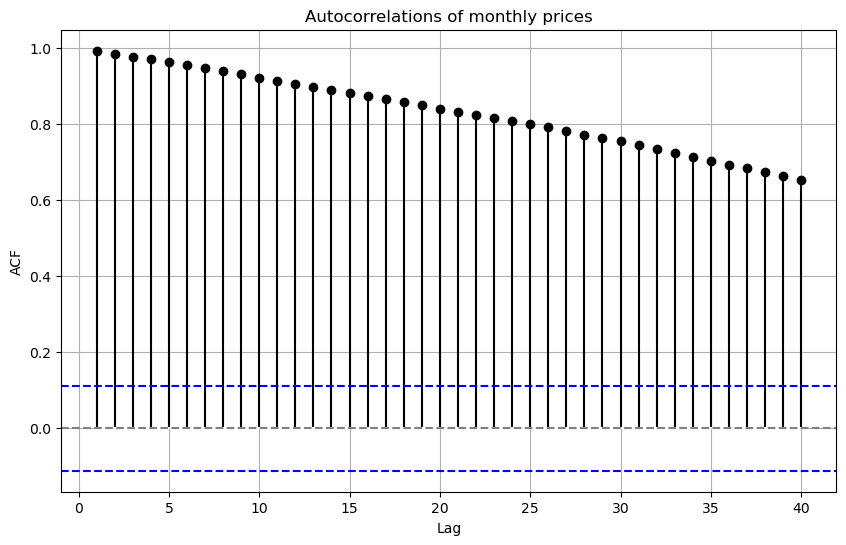

In [27]:
from statsmodels.tsa.stattools import acf

# Calculate empirical autocorrelation
lags = 40
acf_values = acf(pt_m_all, nlags=lags)

# Calculate Bartlett intervals
Bart_Int = 1.96 / np.sqrt(len(pt_m_all))

# Create the autocorrelation plot with Bartlett intervals
plt.figure(figsize=(10, 6))
plt.stem(np.arange(1, lags + 1), acf_values[1:], linefmt='k-', markerfmt='ko', basefmt='w-')
plt.axhline(y=0, color='gray', linestyle='--')
plt.axhline(y=Bart_Int, color='blue', linestyle='--')
plt.axhline(y=-Bart_Int, color='blue', linestyle='--')
plt.title('Autocorrelations of monthly prices')
plt.xlabel('Lag')
plt.ylabel('ACF')
plt.grid(True)

plt.show()

### Histogram of daily prices and normal density


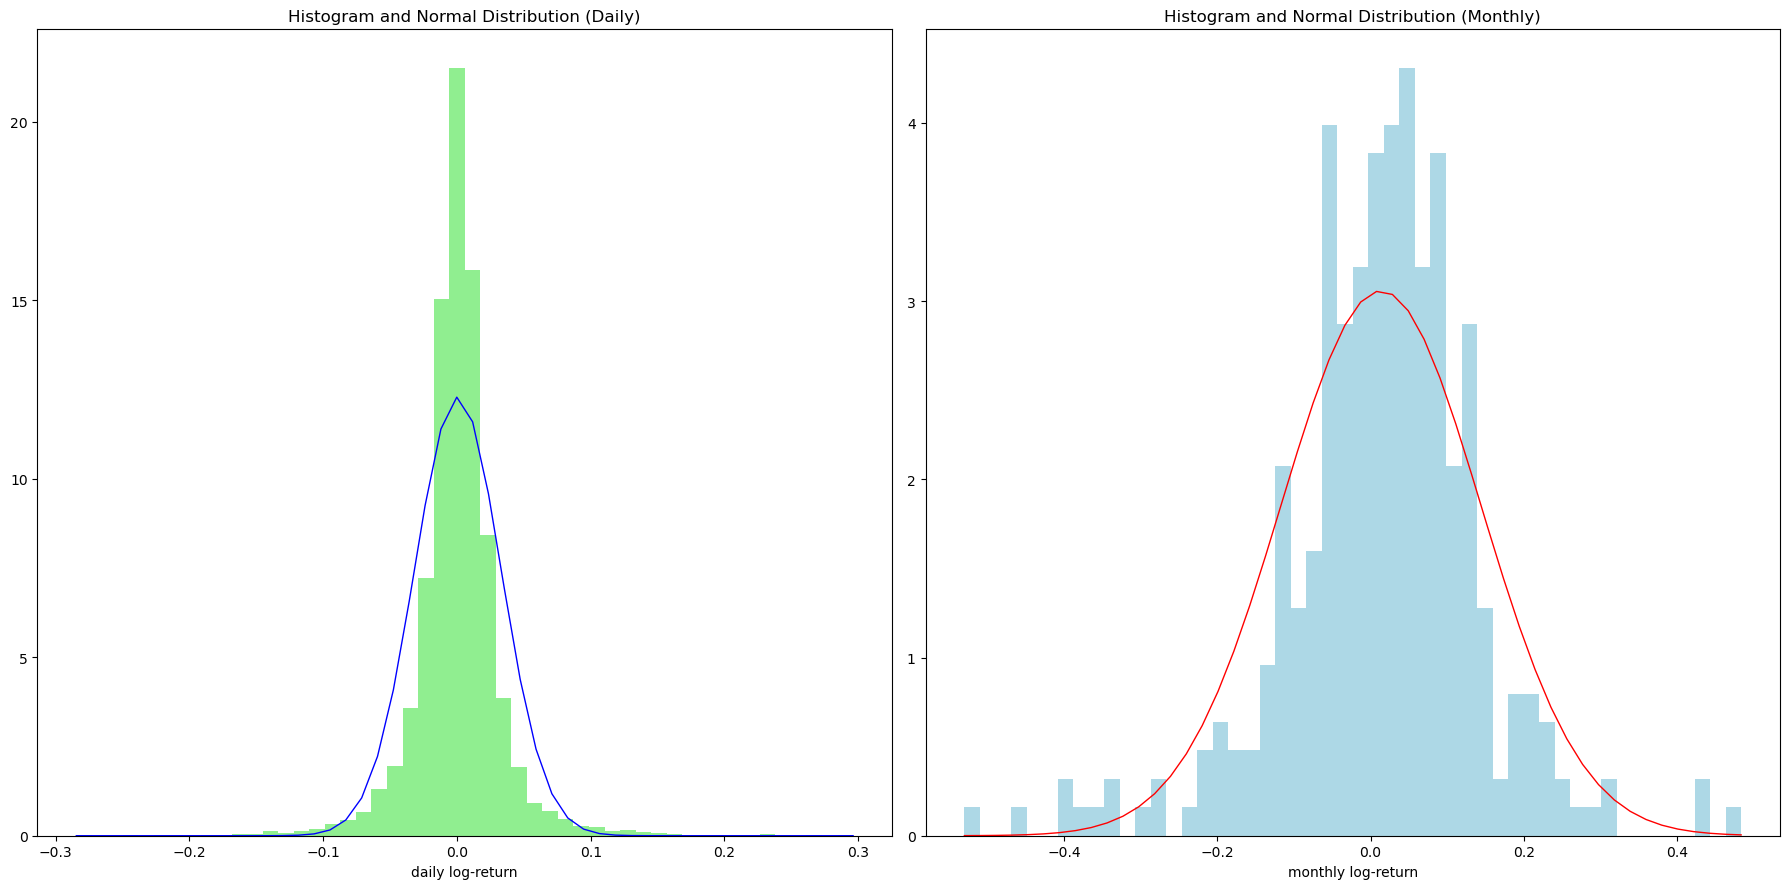

In [29]:
# Set up the subplots
fig, axs = plt.subplots(1, 2, figsize=(18, 9))

# Histogram and Normal Distribution (Daily)
axs[0].hist(rt_d_all, bins=50, density=True, color="lightgreen")
norm_y = stats.norm.pdf(np.linspace(rt_d_all.min(), rt_d_all.max()), loc=np.mean(rt_d_all), scale=np.std(rt_d_all))
axs[0].plot(np.linspace(rt_d_all.min(), rt_d_all.max()), norm_y, color="blue", linewidth=1)
axs[0].set_xlabel("daily log-return")
axs[0].set_title("Histogram and Normal Distribution (Daily)")

# Histogram and Normal Distribution (Monthly)
axs[1].hist(rt_m_all, bins=50, density=True, color="lightblue")
norm_y = stats.norm.pdf(np.linspace(rt_m_all.min(), rt_m_all.max()), loc=np.mean(rt_m_all), scale=np.std(rt_m_all))
axs[1].plot(np.linspace(rt_m_all.min(), rt_m_all.max()), norm_y, color="red", linewidth=1)
axs[1].set_xlabel("monthly log-return")
axs[1].set_title("Histogram and Normal Distribution (Monthly)")

# Adjust layout and display the plot
plt.tight_layout()
plt.show()


### QQ-plot (Normal distribution)

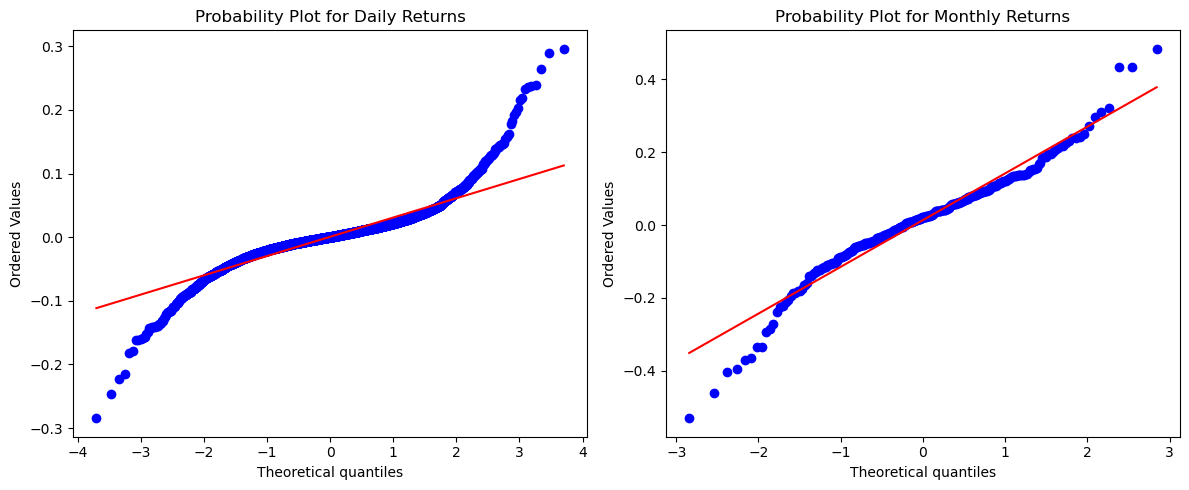

In [30]:
# Set up the subplots
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

# Probability Plot for Daily Returns
stats.probplot(rt_d_all, dist="norm", plot=axs[0])
axs[0].set_title("Probability Plot for Daily Returns")

# Probability Plot for Monthly Returns
stats.probplot(rt_m_all, dist="norm", plot=axs[1])
axs[1].set_title("Probability Plot for Monthly Returns")

# Adjust layout and display the plot
plt.tight_layout()
plt.show()

Check how the QQ-plots change aggregating data

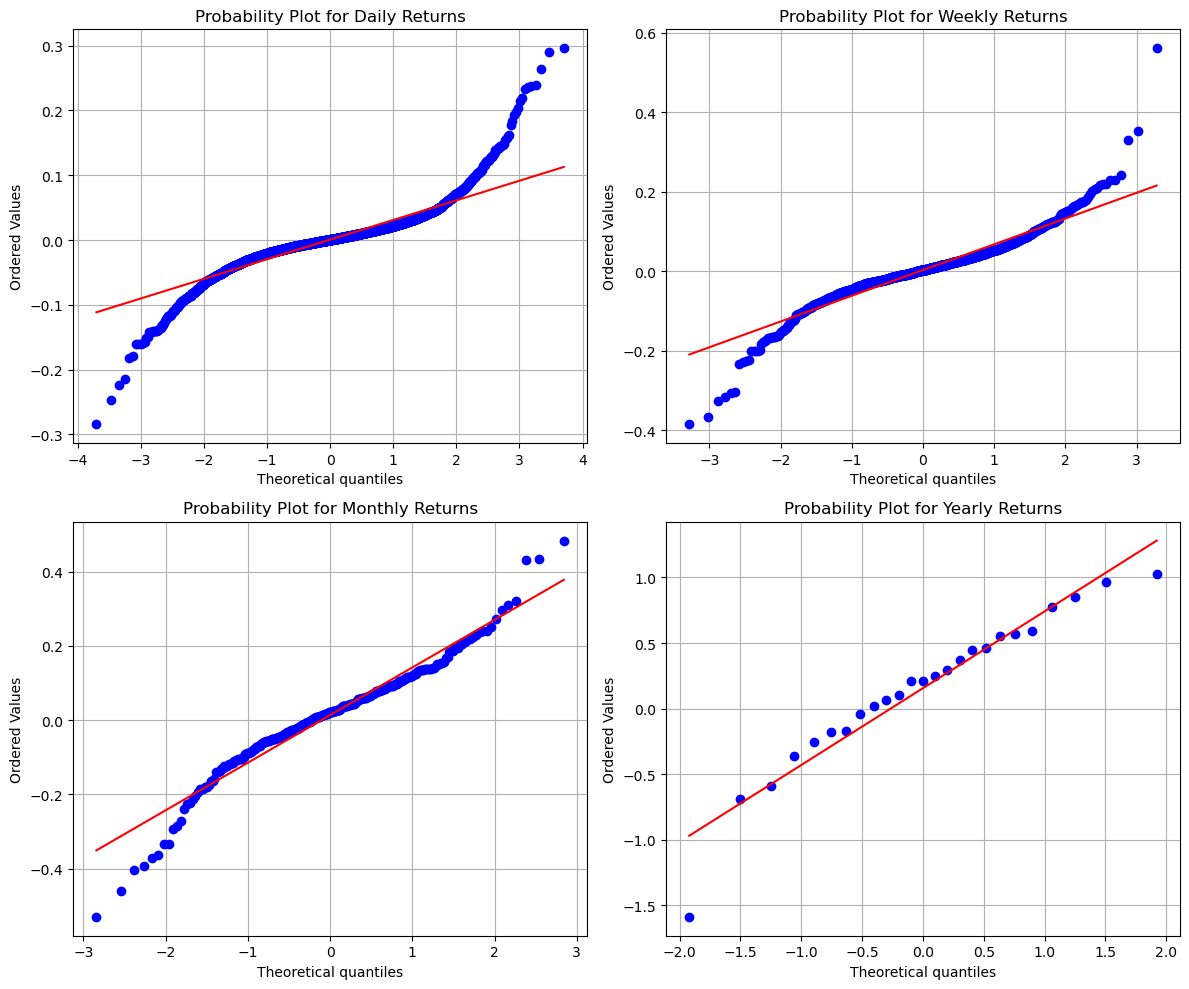

In [32]:
# Set up the subplots
fig, axs = plt.subplots(2, 2, figsize=(12, 10))

# Probability Plot for Daily Returns
stats.probplot(rt_d_all, dist="norm", plot=axs[0, 0])
axs[0, 0].set_title("Probability Plot for Daily Returns")
axs[0, 0].grid(True)

# Probability Plot for Weekly Returns
stats.probplot(rt_w_all, dist="norm", plot=axs[0, 1])
axs[0, 1].set_title("Probability Plot for Weekly Returns")
axs[0, 1].grid(True)

# Probability Plot for Monthly Returns
stats.probplot(rt_m_all, dist="norm", plot=axs[1, 0])
axs[1, 0].set_title("Probability Plot for Monthly Returns")
axs[1, 0].grid(True)

# Probability Plot for Yearly Returns
stats.probplot(rt_y_all, dist="norm", plot=axs[1, 1])
axs[1, 1].set_title("Probability Plot for Yearly Returns")
axs[1, 1].grid(True)

# Adjust layout and display the plot
plt.tight_layout()
plt.show()


### Kernel density 
It is similar to a smooth histogram!

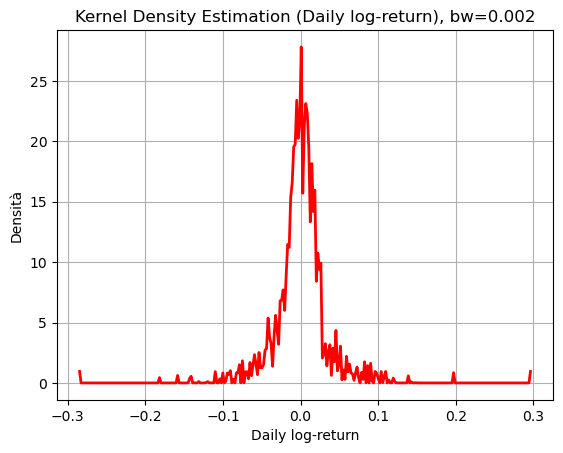

In [34]:
## Compute the kernel density: daily returns
# divide the interval between the min and max returns into 300 segments
density_eval_points = np.linspace(rt_d_all.min(), rt_d_all.max(), num=300)
# estimate the kernel density of our returns
kde = gaussian_kde(rt_d_all, bw_method=0.002)
# and evaluate in the interval defined above
density_estimation = kde(density_eval_points)

# Plotting
plt.plot(density_eval_points, density_estimation, color='red', lw=2, label='Kernel density')
plt.xlabel("Daily log-return")
plt.ylabel("Densità")
plt.title("Kernel Density Estimation (Daily log-return), bw=0.002")
plt.grid(True)
plt.show()

*bw_method* defines the *bandwidth parameter*: 

$\Rightarrow$ the larger the bandwidth, the smoother the histogram:

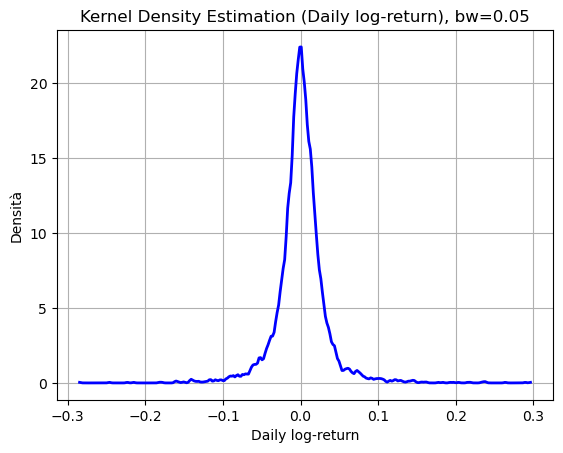

In [36]:
## Compute the kernel density: daily returns
# divide the interval between the min and max returns into 300 segments
density_eval_points = np.linspace(rt_d_all.min(), rt_d_all.max(), num=300)
# estimate the kernel density of our returns
kde = gaussian_kde(rt_d_all, bw_method=0.05)
# and evaluate in the interval defined above
density_estimation = kde(density_eval_points)

# Plotting
plt.plot(density_eval_points, density_estimation, color='blue', lw=2, label='Kernel density')
plt.xlabel("Daily log-return")
plt.ylabel("Densità")
plt.title("Kernel Density Estimation (Daily log-return), bw=0.05")
plt.grid(True)
plt.show()

I can add the histogram...

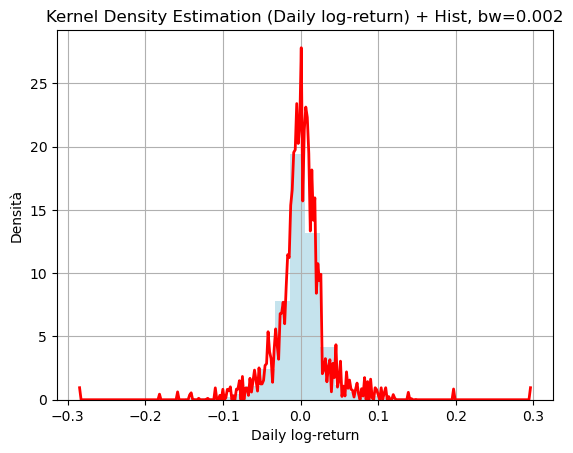

In [37]:
## Compute the kernel density: daily returns
# divide the interval between the min and max returns into 300 segments
density_eval_points = np.linspace(rt_d_all.min(), rt_d_all.max(), num=300)
# estimate the kernel density of our returns
kde = gaussian_kde(rt_d_all, bw_method=0.002)
# and evaluate in the interval defined above
density_estimation = kde(density_eval_points)

# Plotting
plt.hist(rt_d_all, bins=30, density=True, alpha=0.7, color='lightblue')
plt.plot(density_eval_points, density_estimation, color='red', lw=2, label='Kernel density')
plt.xlabel("Daily log-return")
plt.ylabel("Densità")
plt.title("Kernel Density Estimation (Daily log-return) + Hist, bw=0.002")
plt.grid(True)
plt.show()

...and also a normal density...

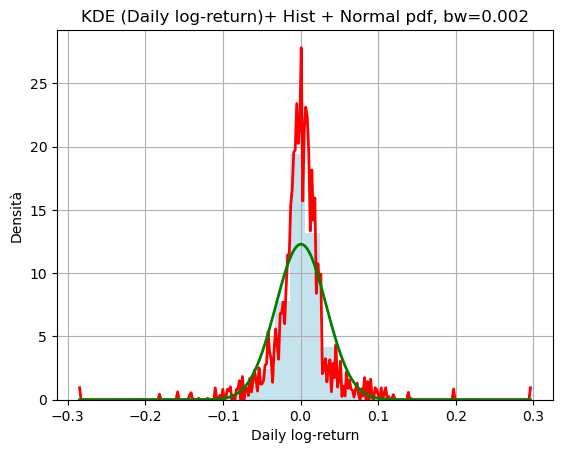

In [38]:
## Compute the kernel density: daily returns
# divide the interval between the min and max returns into 300 segments
density_eval_points = np.linspace(rt_d_all.min(), rt_d_all.max(), num=300)
# estimate the kernel density of our returns
kde = gaussian_kde(rt_d_all, bw_method=0.002)
# and evaluate in the interval defined above
density_estimation = kde(density_eval_points)
# on the same interval, we evaluate a Normal pdf
pdf_theoretical = norm.pdf(density_eval_points, np.mean(rt_d_all), np.std(rt_d_all))

# Plotting
plt.hist(rt_d_all, bins=30, density=True, alpha=0.7, color='lightblue')
plt.plot(density_eval_points, density_estimation, color='red', lw=2, label='Kernel density')
plt.plot(density_eval_points, pdf_theoretical, color='green', lw=2, label='PDF Teorica (Normale)')
plt.xlabel("Daily log-return")
plt.ylabel("Densità")
plt.title("KDE (Daily log-return)+ Hist + Normal pdf, bw=0.002")
plt.grid(True)
plt.show()

...and a vertical line on the mean

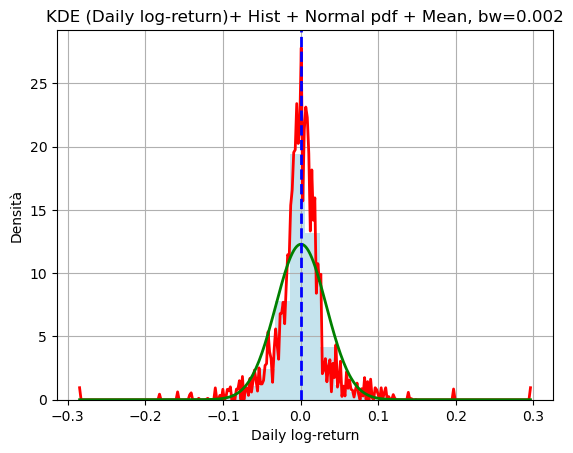

In [39]:
## Compute the kernel density: daily returns
# divide the interval between the min and max returns into 300 segments
density_eval_points = np.linspace(rt_d_all.min(), rt_d_all.max(), num=300)
# estimate the kernel density of our returns
kde = gaussian_kde(rt_d_all, bw_method=0.002)
# and evaluate in the interval defined above
density_estimation = kde(density_eval_points)
# on the same interval, we evaluate a Normal pdf
pdf_theoretical = norm.pdf(density_eval_points, np.mean(rt_d_all), np.std(rt_d_all))
# compute the mean
mean_data = np.mean(rt_d_all)

# Plotting
plt.hist(rt_d_all, bins=30, density=True, alpha=0.7, color='lightblue')
plt.plot(density_eval_points, density_estimation, color='red', lw=2, label='Kernel density')
plt.plot(density_eval_points, pdf_theoretical, color='green', lw=2, label='PDF Teorica (Normale)')
plt.axvline(mean_data, color='blue', linestyle='dashed', linewidth=2, label='Media')

plt.xlabel("Daily log-return")
plt.ylabel("Densità")
plt.title("KDE (Daily log-return)+ Hist + Normal pdf + Mean, bw=0.002")
plt.grid(True)
plt.show()

## Summary Statistics

There is a function which compute some summary statistics...not really the ones we want called describe:

In [40]:
rt_d_all.describe()

count    6475.000000
mean        0.000658
std         0.032465
min        -0.284568
25%        -0.012598
50%         0.000413
75%         0.013969
max         0.296181
Name: rt_d_all, dtype: float64

### Skewness \& Kurtosis

We use the fucntions which came from scipy.stats: 

from scipy.stats import gaussian_kde, norm, iqr, skew, kurtosis, jarque_bera, kstest, anderson

These functions replicate the formulas you find on slides. 

In [42]:
rt_d_skew = skew(rt_d_all, nan_policy='omit')
rt_d_kurt = kurtosis(rt_d_all, nan_policy='omit')

print("The skewness is:", rt_d_skew)
print("The kurtosis is:", rt_d_kurt)

# NOTE: There are several formulas to compute skewness and kurtosis. 
#       These functions both divide the summations of the estimators by 1/T

The skewness is: 0.4304836875303971
The kurtosis is: 11.128625063290052


#### Aggregational Kurtosis
We compute the kurtosis of the daily, weekly, monthly, and annual returns:

In [44]:
rt_d_kurt = kurtosis(rt_d_all, nan_policy='omit')
rt_w_kurt = kurtosis(rt_w_all, nan_policy='omit')
rt_m_kurt = kurtosis(rt_m_all, nan_policy='omit')
rt_y_kurt = kurtosis(rt_y_all, nan_policy='omit')

print("Daily: ", round(rt_d_kurt,3))
print("Weekly: ", round(rt_w_kurt,3))
print("Monthly: ", round(rt_m_kurt,3))
print("Annual: ", round(rt_y_kurt,3))

Daily:  11.129
Weekly:  7.605
Monthly:  2.604
Annual:  1.461


### Normality Tests
Compute Normality tests and sample summary statistics

#### Jarque-Bera Test

In [45]:
JB_rt_d = jarque_bera(rt_d_all)
# first position (0): statistic
print("JB Stat: ", round(JB_rt_d[0],3))
# second position (1): p-value
print("JB p-value: ", JB_rt_d[1])


JB Stat:  33612.686
JB p-value:  0.0


#### See how the jarque_bera() function works

In [46]:
help(stats.jarque_bera)

Help on function jarque_bera in module scipy.stats._stats_py:

jarque_bera(x)
    Perform the Jarque-Bera goodness of fit test on sample data.
    
    The Jarque-Bera test tests whether the sample data has the skewness and
    kurtosis matching a normal distribution.
    
    Note that this test only works for a large enough number of data samples
    (>2000) as the test statistic asymptotically has a Chi-squared distribution
    with 2 degrees of freedom.
    
    Parameters
    ----------
    x : array_like
        Observations of a random variable.
    
    Returns
    -------
    jb_value : float
        The test statistic.
    p : float
        The p-value for the hypothesis test.
    
    References
    ----------
    .. [1] Jarque, C. and Bera, A. (1980) "Efficient tests for normality,
           homoscedasticity and serial independence of regression residuals",
           6 Econometric Letters 255-259.
    
    Examples
    --------
    >>> from scipy import stats
    >>> rng 

#### To inspect the code: 

In [47]:
import inspect

source_code = inspect.getsource(stats.jarque_bera)
print(source_code)

def jarque_bera(x):
    """Perform the Jarque-Bera goodness of fit test on sample data.

    The Jarque-Bera test tests whether the sample data has the skewness and
    kurtosis matching a normal distribution.

    Note that this test only works for a large enough number of data samples
    (>2000) as the test statistic asymptotically has a Chi-squared distribution
    with 2 degrees of freedom.

    Parameters
    ----------
    x : array_like
        Observations of a random variable.

    Returns
    -------
    jb_value : float
        The test statistic.
    p : float
        The p-value for the hypothesis test.

    References
    ----------
    .. [1] Jarque, C. and Bera, A. (1980) "Efficient tests for normality,
           homoscedasticity and serial independence of regression residuals",
           6 Econometric Letters 255-259.

    Examples
    --------
    >>> from scipy import stats
    >>> rng = np.random.default_rng()
    >>> x = rng.normal(0, 1, 100000)
    >>> jarque_b

#### Check the Aggregational Normality: 

In [49]:
print("JB p-value", "daily", "returns:", jarque_bera(rt_d_all)[1])
print("JB p-value", "weekly", "returns:", jarque_bera(rt_w_all)[1])
print("JB p-value", "monthly", "returns:", jarque_bera(rt_m_all)[1])
print("JB p-value", "yearly", "returns:", jarque_bera(rt_y_all)[1])

JB p-value daily returns: 0.0
JB p-value weekly returns: 0.0
JB p-value monthly returns: 0.0
JB p-value yearly returns: 0.04262486815078237


JB test statistics computed manually from formula in the slides:


In [50]:
T = len(rt_y_all)
((T/6)*(skew(rt_y_all))**2)+ (T/24*(kurtosis(rt_y_all)-3)**2)

6.552878015848606

Perform the JB test manually

In [53]:
a = jarque_bera(rt_y_all)
x = rt_y_all 
n = len(x)         ## Number of observations
m1 = sum(x)/n         ## Mean
m2 = sum((x-m1)**2)/n  ## Used in denominator of both
m3 = sum((x-m1)**3)/n  ## For numerator of S
m4 = sum((x-m1)**4)/n  ## For numerator of K
b1 = (m3/m2**(3/2))**2  ## S
b2 = (m4/m2**2)        ## K
STATISTIC = n*b1/6+n*(b2-3)**2/24

print("Manually:",STATISTIC)
print("and using the function:",a[0])


Manually: 6.310634873240035
and using the function: 6.310634873240035


We can also compute the p-value. 
The JB Stats follows a $\chi^2_2$ distribution. So:

In [54]:
p_value = 1 - stats.chi2.cdf(STATISTIC, df=2)
print("The associated p-value is:",p_value)

The associated p-value is: 0.04262486815078237


### Other normality tests: 

#### Lilliefors test:

In [55]:
lill_rt_y = lilliefors(rt_y_all)
print("Stat:",lill_rt_y[0])
print("p-val:",lill_rt_y[1])

Stat: 0.0952201438460884
p-val: 0.7974329823750796


#### Kolmogorov-Smirnov test:

In [56]:
ks_rt_y = kstest(rt_y_all, 'norm')
print("Stat:",ks_rt_y[0])
print("p-val:",ks_rt_y[1])

Stat: 0.24100976414208733
p-val: 0.0919870853397472


#### Anderson-Darling test:

In [57]:
ad_rt_y = anderson(rt_y_all, 'norm')
print("Stat:",ad_rt_y[0])
print("critical val:",ad_rt_y[1])
print("sign level:",ad_rt_y[2])

Stat: 0.34577306424633036
critical val: [0.514 0.586 0.703 0.82  0.975]
sign level: [15.  10.   5.   2.5  1. ]


## Generates table exactly equal to the one in slide n.91
Personalized table of summary statistics. 
The following code creates a 'dictionary' with the data of SP500 sampled at different frequencies. 
We need a disctionary and not a matrix/dataframe, as the vectors have different lengths.


In [59]:
# X contains returns at different frequencies
X = {
    'daily': rt_d_all,
    'weekly': rt_w_all,
    'monthly': rt_m_all,
    'annual': rt_y_all
}

same, but with and without the 1987 market crash

In [60]:
"""

HERE THIS SECTION IS A BIT USELESS BECAUSE WE ALREADY USE THE DATA WITHOUT ANY CRASH


X_87crash_YN = {
    "daily all" : rt_d_all,
    "daily NO 87 Crash" : rt_d_all_noOct87crash
}     
"""             

'\n\nHERE THIS SECTION IS A BIT USELESS BECAUSE WE ALREADY USE THE DATA WITHOUT ANY CRASH\n\n\nX_87crash_YN = {\n    "daily all" : rt_d_all,\n    "daily NO 87 Crash" : rt_d_all_noOct87crash\n}     \n'

In [61]:
def multi_fun(x):
    stat_tab = {
        'Mean': round(np.mean(x) * 100,5),
        'St.Deviation': round(np.std(x) * 100,5),
        'Diameter.C.I.Mean': round(1.96 * np.sqrt(np.var(x) / len(x)) * 100,5),
        'Skewness': round(skew(x),5),
        'Kurtosis': round(kurtosis(x),5),
        'Excess.Kurtosis': round(kurtosis(x) - 3,5),
        'Min': round(np.min(x) * 100,5),
        'Quant5': round(np.quantile(x, 0.05) * 100,5),
        'Quant25': round(np.quantile(x, 0.25) * 100,5),
        'Median': round(np.quantile(x, 0.50) * 100,5),
        'Quant75': round(np.quantile(x, 0.75) * 100,5),
        'Quant95': round(np.quantile(x, 0.95) * 100,5),
        'Max': round(np.max(x) * 100,5),
        'Jarque.Bera.stat': round(jarque_bera(x)[0],5),
        'Jarque.Bera.pvalue.X100': round(jarque_bera(x)[1] *100,5),
        'Lillie.test.stat': round(lilliefors(x)[0],5),
        'Lillie.test.pvalue.X100': round(lilliefors(x)[1] * 100,5),
        'N.obs': len(x)
    }
    return stat_tab 
    

In [63]:
print("daily:",lilliefors(rt_d_all))
print("weekly:",lilliefors(rt_w_all))
print("monthly:",lilliefors(rt_m_all))
print("ann:",lilliefors(rt_y_all))

daily: (0.10234931825907423, 0.0009999999999998899)
weekly: (0.09550229371760896, 0.0009999999999998899)
monthly: (0.08174420605333757, 0.0009999999999998899)
ann: (0.0952201438460884, 0.7974329823750796)


https://www.statsmodels.org/dev/generated/statsmodels.stats.diagnostic.lilliefors.html

1. Define a new dictionary to store the stats:

    a. key will contains the key (i.e., daily, weekly, ...)
    
    b. data will contains the returns
    
    
2. Apply *multi_fun* to each data series
3. Define a DataFrame with the stats results
4. Print the dictionary

In [64]:
# 1. 
statistics_dict = {}

# 2.
statistics_dict = {
    key: multi_fun(data.iloc[1:]) 
    for key, data in X.items()
}
# apply multi_fun to each returns ("series" in pandas) 
# which is located in one of the four key of our dictionary X   
# 3.
statistics_df = pd.DataFrame(statistics_dict)

# 4.
print(statistics_df)


                               daily      weekly    monthly     annual
Mean                         0.06351     0.31014    1.32164   22.85692
St.Deviation                 3.24131     6.76830   13.06275   45.28052
Diameter.C.I.Mean            0.07896     0.36213    1.45887   18.11598
Skewness                     0.41992     0.05008   -0.45895   -0.15137
Kurtosis                    11.15158     7.60655    2.59462   -0.64793
Excess.Kurtosis              8.15158     4.60655   -0.40538   -3.64793
Min                        -28.45678   -38.51804  -53.02674  -68.54809
Quant5                      -4.61051    -9.74288  -20.16713  -55.72274
Quant25                     -1.25994    -2.64062   -4.98163   -7.23999
Median                       0.04108     0.30519    2.09626   23.07665
Quant75                      1.39659     3.40897    8.45973   55.96192
Quant95                      4.47118    10.67416   20.90661   94.77653
Max                         29.61811    56.11507   48.35221  102.44636
Jarque